# **Object Detection**

Importing Packages for Object Detection, Scenery Detection, Keywords to Sentence and Audio conversion

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import IPython
from IPython.display import Image
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
import sys
sys.path.insert(0,'Scenery Detection/')

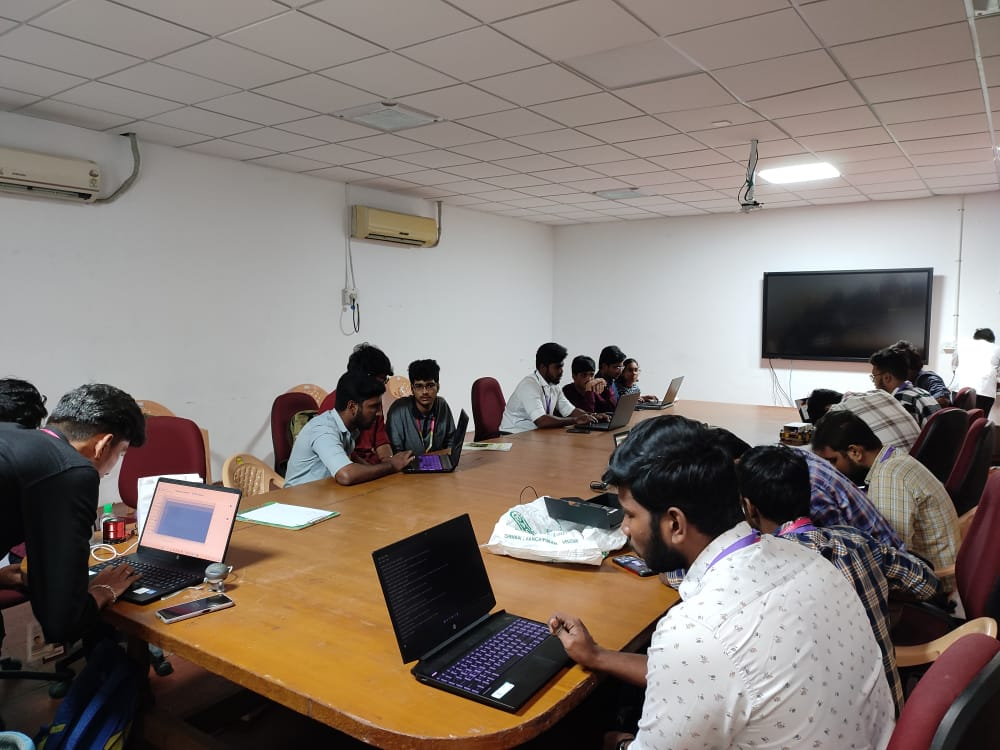

In [3]:
path = "Test Images/designsummit.jpg"
Image(path)

In [5]:
model = torch.hub.load('Object Detection/yolov5/', 'yolov5s', source='local', pretrained=True)

YOLOv5  2023-8-12 Python-3.10.6 torch-2.0.1+cpu CPU



Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Saved 1 image to OD_Out


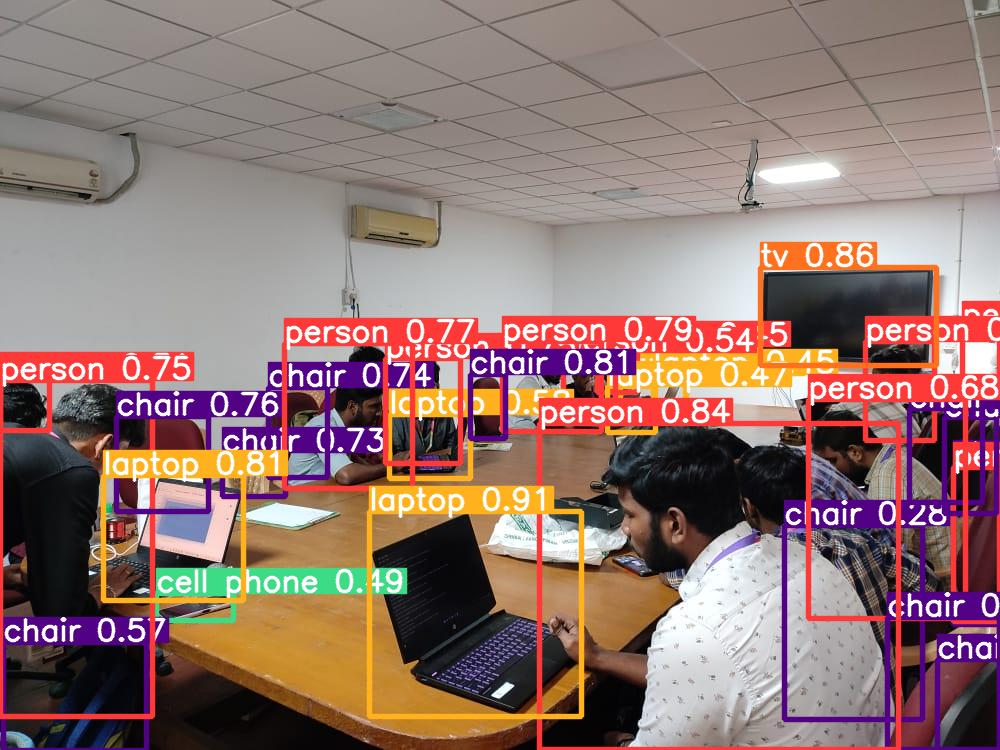

In [6]:

results = model(path)
results.save(save_dir='OD_Out/')
Image('OD_Out/{}'.format(os.path.basename(path)))

In [7]:
objdetdata = results.display(pprint="True") 

image 1/1: 750x1000 12 persons, 11 chairs, 1 tv, 6 laptops, 1 cell phone


In [8]:
print(objdetdata)

['12-persons', '11-chairs', '1-tv', '6-laptops', '1-cell phone']


# **Scenery Detection**

hacky way to deal with the Pytorch 1.0 update

In [9]:
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

Preparing the labels, MOdels, Transformers,...

In [10]:
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'Scenery_Detection/categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'Scenery_Detection/IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'Scenery_Detection/labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'Scenery_Detection/W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

In [11]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))


In [12]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [13]:
def returnTF():
    # load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [15]:
def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'Scenery_Detection/wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    from Scenery_Detection import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

Loading the labels, MOdels, Transformers,...

In [16]:
from PIL import Image
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# load the test image
img_url = path
os.system('wget %s -q -O test.jpg' % img_url)
img = Image.open(img_url)
input_img = V(tf(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [17]:
scenecat = []; sceneattr = []
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
temp = str(classes[idx[1]])
temp = temp.replace("_","-")
scenecat.append(temp)

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))
for i in range(-1,-10,-1):
    temp = str(labels_attribute[idx_a[i]])
    temp = temp.replace(" ","-")
    sceneattr.append(temp)


# generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread(img_url)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('SD_Out/cam.jpg', result)

--TYPE OF ENVIRONMENT: indoor
--SCENE CATEGORIES:
0.380 -> legislative_chamber
0.186 -> conference_room
0.161 -> lecture_room
0.151 -> classroom
0.043 -> computer_room
--SCENE ATTRIBUTES:
enclosed area, no horizon, man-made, congregating, cloth, indoor lighting, working, wood, studying
Class activation map is saved as cam.jpg


True

output the IO prediction, scene category, scene attributes, output image and generating class activation mapping

# Joining the Keywords, Forming the sentence and then Converting the sentence into audio

Joining the keywords

In [19]:
print(objdetdata)
print(scenecat)
print(sceneattr)

['12-persons', '11-chairs', '1-tv', '6-laptops', '1-cell phone']
['conference-room']
['enclosed-area', 'no-horizon', 'man-made', 'congregating', 'cloth', 'indoor-lighting', 'working', 'wood', 'studying']


In [21]:
keys = objdetdata + scenecat + sceneattr
keys

['12-persons',
 '11-chairs',
 '1-tv',
 '6-laptops',
 '1-cell phone',
 'conference-room',
 'enclosed-area',
 'no-horizon',
 'man-made',
 'congregating',
 'cloth',
 'indoor-lighting',
 'working',
 'wood',
 'studying']

Keyword To Sentence

In [27]:
from keytotext import pipeline
nlp = pipeline("mrm8488/t5-base-finetuned-common_gen") 
sentence = (nlp(keys))
print(sentence)

A group of people, including 12-persons, 11-chairs, 6-laptops, 1-cell phone and a conference room, are congregating in an enclosed area with wood and no horizon.


Sentence To Audio

In [30]:
from gtts import gTTS
from playsound import playsound
language = 'en'
obj = gTTS(sentence, lang=language, slow=False)
path = "ita.mp3"
obj.save(path)
os.system("mpg321 "+path)
playsound(path)
os.remove("ita.mp3")